In [1]:
import  matplotlib.pyplot as plt
import numpy as np
import re
import shutil
import os
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing

In [2]:
print(tf.__version__)

2.18.0


In [3]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

84125825/84125825 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [4]:
dataset_dir = os.path.join('/content/aclImdb_v1', 'aclImdb')
dataset_dir

'/content/aclImdb_v1/aclImdb'

In [5]:
os.listdir(dataset_dir)

['README', 'train', 'imdbEr.txt', 'test', 'imdb.vocab']

In [6]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['unsupBow.feat',
 'labeledBow.feat',
 'pos',
 'neg',
 'urls_neg.txt',
 'urls_unsup.txt',
 'urls_pos.txt',
 'unsup']

In [7]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


# Load the Dataset
with `text_dataset_from_directory` utility which expects a directory structure as follows.

* need 2 folders on disk, corresponding to `class_a` and `class_b`.

and divide the dataset into positive and negative.

In [8]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

In [9]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
  '/content/aclImdb_v1/aclImdb/train',
  batch_size=batch_size,
  validation_split=0.2,
  subset='training',
  seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [10]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

In [11]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


In [12]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    '/content/aclImdb_v1/aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed
)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [13]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    '/content/aclImdb_v1/aclImdb/test',
    batch_size=batch_size
)

Found 25000 files belonging to 2 classes.


# Preparing the dataset for training
---
**Standarize** refers to preprocessing the text, typically to remove punctuation or HTML to simplify the dataset.

**Tokenization** refers to splitting strings into tokens.

**Vectorization** refers to converting tokens into numbers so they can be fed into a neural network.



In [14]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

In [15]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length
)

In [16]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y : x)
vectorize_layer.adapt(train_text)

In [17]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [18]:
# Retrive a batch (of 32 revews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Silent Night, Deadly Night 5 is the very last of the series, and like part 4, it\'s unrelated to the first three except by title and the fact that it\'s a Christmas-themed horror flick.<br /><br />Except to the oblivious, there\'s some obvious things going on here...Mickey Rooney plays a toymaker named Joe Petto and his creepy son\'s name is Pino. Ring a bell, anyone? Now, a little boy named Derek heard a knock at the door one evening, and opened it to find a present on the doorstep for him. Even though it said "don\'t open till Christmas", he begins to open it anyway but is stopped by his dad, who scolds him and sends him to bed, and opens the gift himself. Inside is a little red ball that sprouts Santa arms and a head, and proceeds to kill dad. Oops, maybe he should have left well-enough alone. Of course Derek is then traumatized by the incident since he watched it from the stairs, but he doesn\'t grow up to be some killer Santa, he just stops talking.<br /><br />T

In [19]:
print("1287 ----> ", vectorize_layer.get_vocabulary()[1287])
print("313  ----> ", vectorize_layer.get_vocabulary()[313])

1287 ---->  silent
313  ---->  night


In [20]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

# Configuring the Dataset for Performance
---

In [21]:
AUTOTUNE = tf.data.AUTOTUNE


train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [22]:
embedding_dim = 16

In [24]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(max_features, embedding_dim),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_1           │ ?                           │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# The layers are stacked sequentially to build the classifier:

   The first layer is an Embedding layer. This layer takes the integer-encoded reviews and looks up an embedding vector for each word-index. These vectors are learned as the model trains.
   
  The vectors add a dimension to the output array. The resulting dimensions are: (batch, sequence, embedding). To learn more about embeddings, check out the Word embeddings tutorial.
  
  Next, a GlobalAveragePooling1D layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.

  The last layer is densely connected with a single output node.


In [25]:
# Loss Function and optimizer.

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[tf.metrics.BinaryAccuracy(threshold=0.5)]
)

In [26]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - binary_accuracy: 0.5248 - loss: 0.8593 - val_binary_accuracy: 0.7870 - val_loss: 0.6335
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - binary_accuracy: 0.6978 - loss: 0.6142 - val_binary_accuracy: 0.8110 - val_loss: 0.5237
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.7990 - loss: 0.4904 - val_binary_accuracy: 0.8070 - val_loss: 0.4456
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - binary_accuracy: 0.8437 - loss: 0.4482 - val_binary_accuracy: 0.6166 - val_loss: 4.8303
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - binary_accuracy: 0.7060 - loss: 2.4072 - val_binary_accuracy: 0.8368 - val_loss: 0.4098
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - binary_accuracy: 0.7871 - loss: 0.8696 - val_binary_accuracy: 0.8390 - val_loss: 0.4074
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - binary_accuracy: 0.8271 - loss: 0.5266 - val_binary_accuracy: 0.8718 - val_loss: 0.3781
Epoch 

In [27]:
loss, accuracy = model.evaluate(test_ds)

print("Loss : ", loss)
print("Accuracy : ", accuracy)

782/782 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - binary_accuracy: 0.8667 - loss: 0.3914
Loss :  0.39254000782966614
Accuracy :  0.866919994354248


In [28]:
history_dict = history.history
history_dict.keys()

dict_keys(['binary_accuracy', 'loss', 'val_binary_accuracy', 'val_loss'])

[]

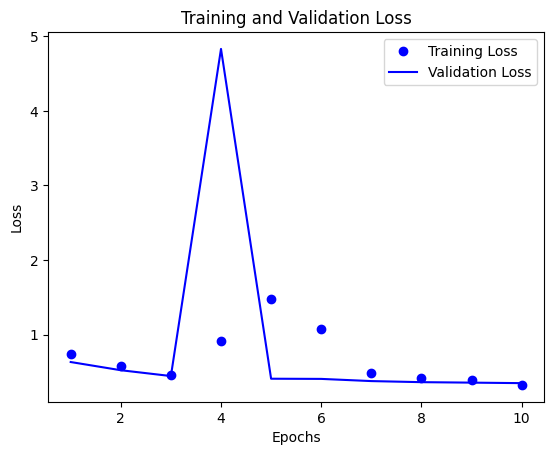

In [30]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.plot()

[]

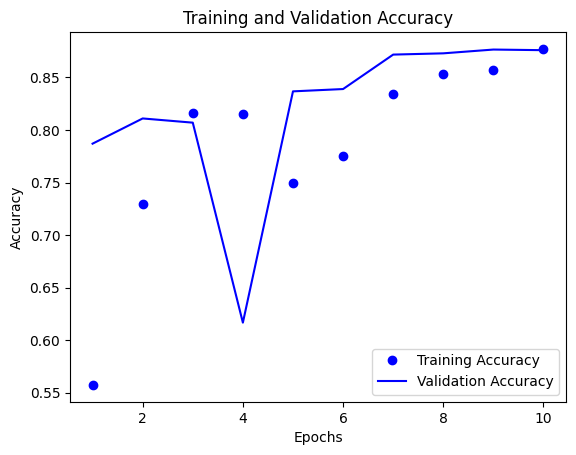

In [31]:
plt.plot(epochs, acc, 'bo', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

In [33]:
export_model = tf.keras.Sequential([
    vectorize_layer,
    model,
    layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(),
    optimizer='adam',
    metrics=['accuracy']
)

metrics = export_model.evaluate(raw_test_ds)
print(metrics)

782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6460 - loss: 0.5869
[0.5853529572486877, 0.6513599753379822]


In [34]:
examples = tf.constant([
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
])

export_model.predict(examples)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step


array([[0.6296428],
       [0.6172158],
       [0.6068372]], dtype=float32)